## Conditional module

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
from sklearn.metrics import classification_report, f1_score, accuracy_score

class Unconditional(object):
    def __init__(self, dimension, generator, latent_size, latent_dist, use_cuda=False):
        self.use_cuda = use_cuda

        self.dimension = dimension
        self.generator = generator

        if self.use_cuda:
            self.generator = self.generator.cuda()

        self.latent_size = latent_size
        self.latent_dist = latent_dist

    def sample_batch(self, batch, m):
        config = [batch, self.latent_size]# + m
        zhat = None
        if self.use_cuda:
            zhat = Variable(torch.FloatTensor(*config).cuda(), requires_grad=True)
        else:
            zhat = Variable(torch.FloatTensor(*config), requires_grad=True)
        zhat.retain_grad()
        if self.latent_dist == "normal":
            zhat.data = zhat.data.normal_(0, 1)
        elif self.latent_dist == "uniform":
            zhat.data = zhat.data.uniform_(-1, 1)
        return zhat

    def create_unconditional_simulations(self, batch, m):
        zhat = self.sample_batch(batch, m)
        if self.use_cuda:
            zhat = zhat.cuda()
        try:
            xhat = self.generator(zhat)
            return xhat.data.cpu().numpy()
        except RuntimeError as reError:
            print(reError)


class Conditioner(object):
    def __init__(self, dimension, generator, latent_size, conditioning_data,
                 mask, real_sample=None, latent_dist="normal", discriminator=None,
                 use_cuda=False, verbose=False, tensorboard=None, is_binary=False, conditioner_vec=None):
        # Set arguments
        self.use_cuda = use_cuda
        self.dimension = dimension
        self.generator = generator
        self.latent_size = latent_size
        self.latent_dist = latent_dist
        self.discriminator = discriminator

        if self.discriminator is not None:
            for p in self.discriminator.parameters():
                p.requires_grad = False

        for p in self.generator.parameters():
            p.requires_grad = False

        if self.use_cuda:
            self.generator = self.generator.cuda()
            if self.discriminator is not None:
                self.discriminator = self.discriminator.cuda()

        self.conditioning_data = conditioning_data
        self.mask = mask
        self.unique = np.unique(self.mask, return_counts=True)[0]
        self.optimizer = None
        self.count = [0]
        self.verbose = verbose
        self.tensorboard = tensorboard
        self.is_binary = is_binary
        self.conditioner_vec = conditioner_vec
        self.real_sample = real_sample
        self.first = True
        self.content_loss = None
        self.perceptual = None
        self.total_loss = None
        self.content_criterion = nn.MSELoss()

    def sample_batch(self, batch, m):
        config = [batch, self.latent_size]#+m
        if self.use_cuda:
            zhat = Variable(torch.FloatTensor(*config).cuda(), requires_grad=True)
        else:
            zhat = Variable(torch.FloatTensor(*config), requires_grad=True)
        zhat.retain_grad()
        if self.latent_dist == "normal":
            zhat.data = zhat.data.normal_(0, 1)
        elif self.latent_dist == "uniform":
            zhat.data = zhat.data.uniform_(-1, 1)
        return zhat
        return self.steps, self.content_losses[-1], self.zhat

    def condition_logloss(self, batch, m, steps:int=100):
        self.batch = batch
        self.m = m
        self.zhat = self.sample_batch(batch, m)
        self.optimizer = optim.Adam([self.zhat], lr=1e-3)
        self.perceptual_losses, self.content_losses, self.total_losses = [], [], []
        
        self.real_sample = Variable(torch.from_numpy(np.array([np.expand_dims(self.real_sample, 0)]*self.batch)).float())
        
        self.conditioning_data = Variable(torch.from_numpy(np.array([np.expand_dims(self.conditioning_data, 0)]*self.batch)).float())
        self.mask = Variable(torch.from_numpy(np.array([np.expand_dims(self.mask, 0)]*self.batch)).float())
        if self.use_cuda:
            self.conditioning_data = self.conditioning_data.cuda()
            self.mask = self.mask.cuda()
            self.real_sample = self.real_sample.cuda()

        disc_real = None
        if self.discriminator:
            disc_real = self.discriminator(self.real_sample).mean()

        self.criterion = nn.BCELoss(weight=self.mask)
        for i in range(steps):
            self.optimizer.zero_grad()
            completed = self.generator(self.zhat)
            content_loss = self.criterion(completed*0.5+0.5, self.conditioning_data)
            perceptual = None

            if self.discriminator:
                perceptual = self.discriminator(completed).mean()
                perceptual = (disc_real - perceptual).abs()
                perceptual.backward(retain_graph=True)

            content_loss.backward(retain_graph=True)
            total_loss = content_loss
            if self.discriminator:
                total_loss = content_loss - perceptual

            out = np.where((completed*0.5+0.5).data.cpu().numpy()[0, 0][:,:].reshape(-1) >= 0.5, 1., 0)
            bin_labels = self.conditioning_data.data.cpu().numpy()[0, 0][:, :].reshape(-1)

            percep_np, content_np, total_np = self.get_numpy_values([perceptual, content_loss, total_loss])
            if self.verbose:
                print(f"Iteration={i}\nF1-Score={round(f1_score(out, bin_labels, average=None)[0], 2)}\n"+
                      f"Accuracy={round(accuracy_score(out, bin_labels),2)}\nPerceptual loss={percep_np}\n"+
                      f"Content loss={content_loss}\nTotal loss={total_loss}")

            self.append_losses([percep_np, content_np, total_np])            
            if 0.85<=f1_score(out, bin_labels, average=None)[0] <= 1.0 and total_loss < 1.0:
                print("Finished conditioning in ", i, " steps.")
                break

            self.optimizer.step()

            if i == 50:
                print("Reducing learning rate...")
                fig, ax = plt.subplots(1, 2, figsize=(16,9))
                ax[0].imshow(out.reshape(64,64))
                ax[0].set_title("Generated image")
                
                ax[1].imshow(bin_labels.reshape(64,64))
                ax[1].set_title("Labels")
                
                self.optimizer = optim.Adam([self.zhat], lr=1e-4, betas=(0.5, 0.9))

        return i, percep_np, content_np, total_np, self.zhat

    def closure(self):
        self.optimizer.zero_grad()
        completed = self.generator(self.zhat)

        if self.is_binary:
            completed.data = torch.sign(completed.data)

        completed_masked = completed*self.mask

        self.content_loss = torch.sum(torch.pow(self.conditioning_masked - completed_masked, 2))
        
        if self.discriminator:
            self.perceptual = self.discriminator(completed).mean()*1e-2

        self.total_loss = self.content_loss
        if self.discriminator:
            self.total_loss = self.content_loss - self.perceptual

        self.total_loss.backward(retain_graph=True)
        percep_np, content_np, total_np = self.get_numpy_values([-self.perceptual, self.content_loss, self.total_loss])
        self.append_losses([percep_np, content_np, total_np])

        if self.tensorboard is not None:
            if self.perceptual is not None:
                self.tensorboard.add_scalar(scalar_value=percep_np, tag="Perceptual Loss", global_step=self.count[0])
            self.tensorboard.add_scalar(scalar_value=content_np, tag="Content Loss", global_step=self.count[0])
            self.tensorboard.add_scalar(scalar_value=total_np, tag="Total Loss", global_step=self.count[0])

        if self.verbose:
            print("Iteration: ", self.count[0],
                  "Current MSE: %.1f" % float(content_np),
                  " Current Perceptual Loss: %.3f" %float(percep_np),
                  " Current Total Loss: %.3f" %float(total_np),
                  " Target MSE: %.2f"%self.target
                  )
        self.count[0] += 1

        return self.total_loss

    def get_numpy_values(self, variables):
        numpy_values = []
        for v in variables:
            if v is not None:
                numpy_values.append(v.data.cpu().numpy())
            else:
                numpy_values.append(None)
        return numpy_values

    def append_losses(self, losses):
        self.perceptual_losses.append(losses[0])
        self.content_losses.append(losses[1])
        self.total_losses.append(losses[2])

## Loading weights to network

In [2]:
import os
import cv2
import yaml
import time
import torch
import shutil
import torchvision
import tensorboardX
import torch.nn as nn
import torchvision.transforms as transforms

from tqdm import tqdm
from imageio import imsave
from torch.autograd import grad
from torchsummary import summary
from torch.autograd import Variable
from skimage.util import view_as_windows


"""
WGAN-GP implementation.

This is an implementation of Wasserstein GANs with gradient penalty.
Link to the paper is : https://arxiv.org/pdf/1704.00028.pdf

Wasserstein GANs suggest a change in the distance function calculated while
 training any Generative Adverserial Network.
"""


class GeneratorModel(nn.Module):
    """
    Generator model for WGAN-GP.

    Given a vector of random values (latent inputs) as input, this network
    generates data with the same structure as the training data.
    The goal is to train the generator to generate data that "fools" the
    Critic.
    """

    def __init__(self, dim_in, dim: int = 128):
        super(GeneratorModel, self).__init__()

        def genblock(dim_in, dim_out):
            
            block = nn.Sequential(nn.ConvTranspose2d(in_channels=dim_in,
                                                     out_channels=dim_out,
                                                     kernel_size=5,
                                                     stride=2,
                                                     padding=2,
                                                     output_padding=1,
                                                     bias=False),
                                  nn.BatchNorm2d(dim_out),
                                  nn.ReLU()
                                  )
            return block

        def genimg(dim_in):
            block = nn.Sequential(nn.ConvTranspose2d(in_channels=dim_in,
                                                     out_channels=1,
                                                     kernel_size=5,
                                                     stride=2,
                                                     padding=2,
                                                     output_padding=1,
                                                     ),
                                  nn.Tanh()
                                  )
            return block

        self.prepare = nn.Sequential(nn.Linear(dim_in, dim*8*4*4, bias=False),
                                     nn.BatchNorm1d(dim*8*4*4),
                                     nn.ReLU())
        self.generate = nn.Sequential(genblock(dim*8, dim*4),
                                      genblock(dim*4, dim*2),
                                      genblock(dim*2, dim*4),
                                      genblock(dim*4, dim*8),
                                      genimg(dim*8))

    def forward(self, x):
        """Forward pass function."""
        x = self.prepare(x)
        x = x.view(x.size(0), -1, 4, 4)
        x = self.generate(x)
        return x


class CriticModel(nn.Module):
    """
    Critic model for WGAN-GP.

    Given batches of data containing observations from both the training data,
    and generated data from the generator, this network attempts to classify
    the observations as "real" or "generated".
    The goal is to train the discriminator to distinguish between real and
    generated data.
    """

    def __init__(self, dim_in, dim=128):
        super(CriticModel, self).__init__()

        def critic_block(dim_in, dim_out):
            block = nn.Sequential(nn.Conv2d(in_channels=dim_in,
                                            out_channels=dim_out,
                                            kernel_size=5,
                                            stride=2,
                                            padding=2),
                                  nn.InstanceNorm2d(dim_out, affine=True),
                                  nn.LeakyReLU(0.2))
            return block

        self.analyze = nn.Sequential(nn.Conv2d(in_channels=dim_in,
                                               out_channels=dim,
                                               kernel_size=5,
                                               stride=2,
                                               padding=2),
                                     nn.LeakyReLU(0.2),
                                     critic_block(dim, dim*2),
                                     critic_block(dim*2, dim*4),
                                     critic_block(dim*4, dim*8),
                                     nn.Conv2d(in_channels=dim*8,
                                               out_channels=1,
                                               kernel_size=4))

    def forward(self, x):
        """Forward pass function."""
        x = self.analyze(x)
        x = x.view(-1)
        return x


latent_size = 100

state_dict = torch.load("../../Downloads/.checkpoints/Epoch_(100).ckpt", map_location='cpu')

generator = GeneratorModel(latent_size)
generator.load_state_dict(state_dict["Generator"])

discriminator = CriticModel(1)
discriminator.load_state_dict(state_dict["D"])

<All keys matched successfully>

In [3]:
uncond = Unconditional(1, generator, latent_size, "normal")
x = 1
for i in range(1, 3):
    samples = uncond.create_unconditional_simulations(3, [i, i, i])
    if samples is not None:
        print("Imsize: ", i, "Uncoditional Simulation Size: ", samples.shape)

Imsize:  1 Uncoditional Simulation Size:  (3, 1, 128, 128)
Imsize:  2 Uncoditional Simulation Size:  (3, 1, 128, 128)
Imsize:  3 Uncoditional Simulation Size:  (3, 1, 128, 128)
Imsize:  4 Uncoditional Simulation Size:  (3, 1, 128, 128)
Imsize:  5 Uncoditional Simulation Size:  (3, 1, 128, 128)
Imsize:  6 Uncoditional Simulation Size:  (3, 1, 128, 128)
Imsize:  7 Uncoditional Simulation Size:  (3, 1, 128, 128)
Imsize:  8 Uncoditional Simulation Size:  (3, 1, 128, 128)
Imsize:  9 Uncoditional Simulation Size:  (3, 1, 128, 128)
Imsize:  10 Uncoditional Simulation Size:  (3, 1, 128, 128)
Imsize:  11 Uncoditional Simulation Size:  (3, 1, 128, 128)
Imsize:  12 Uncoditional Simulation Size:  (3, 1, 128, 128)
Imsize:  13 Uncoditional Simulation Size:  (3, 1, 128, 128)
Imsize:  14 Uncoditional Simulation Size:  (3, 1, 128, 128)
Imsize:  15 Uncoditional Simulation Size:  (3, 1, 128, 128)
Imsize:  16 Uncoditional Simulation Size:  (3, 1, 128, 128)
Imsize:  17 Uncoditional Simulation Size:  (3, 1,

In [5]:
from tqdm import tqdm_notebook

samples = []
for i in tqdm_notebook(range(100)):
    samples.append(uncond.create_unconditional_simulations(3, [2, 4*2, 4*4]).reshape(3, 1, 128, 128))

/tmp/ipykernel_31/672494221.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(100)):


  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Generated image')

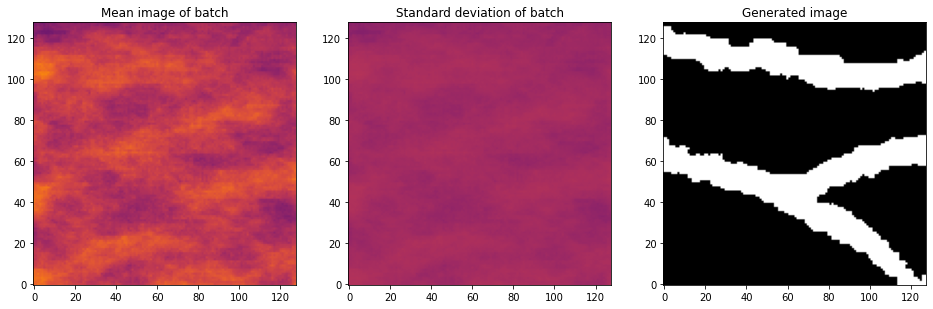

In [7]:
import matplotlib.pyplot as plt

samples_arr = np.where(np.concatenate(samples, 0)*0.5+0.5 >= 0.5, 1.0, 0.0)
mean = np.mean(samples_arr, axis=0)
std = np.std(samples_arr, axis=0)

fig, ax = plt.subplots(1, 3, figsize=(16, 9))
ax[0].imshow(mean[0], cmap="inferno",
             origin='lower', vmin=0.0, vmax=0.5,)
ax[0].set_title("Mean image of batch")

ax[1].imshow(std[0], cmap="inferno",
             origin='lower', vmin = 0.0, vmax=1)
ax[1].set_title("Standard deviation of batch")

ax[2].imshow(samples_arr[1].reshape(128, 128), cmap="gray",
            origin='lower')
ax[2].set_title("Generated image")

/tmp/ipykernel_31/1512285113.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


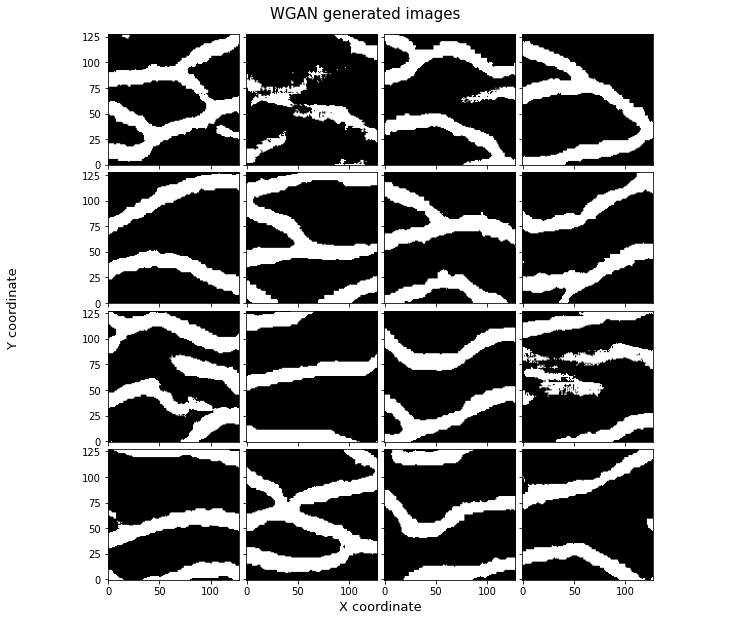

In [14]:
import random

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10, 9))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, samples_arr[50:66]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im.reshape(128, 128), cmap="gray", origin="lower")

fig.suptitle("WGAN generated images", fontsize=15)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("X coordinate", size=13)
plt.ylabel("Y coordinate", size=13)

fig.tight_layout()

plt.show()

/tmp/ipykernel_31/1016342673.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


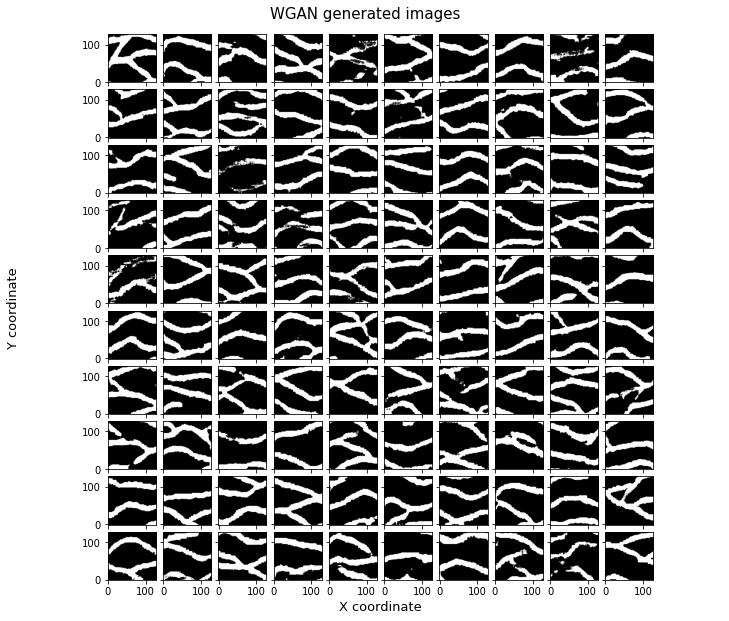

In [24]:
import random

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10, 9))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(10, 10),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, samples_arr[200:300]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im.reshape(128, 128), cmap="gray", origin="lower")

fig.suptitle("WGAN generated images", fontsize=15)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("X coordinate", size=13)
plt.ylabel("Y coordinate", size=13)

fig.tight_layout()

plt.show()

In [39]:
import os

os.makedirs("wgan/output", exist_ok=True)

for idx, im in enumerate(samples_arr[200:300]):
    image = im.reshape(128,128)
    image_resized = cv2.resize(image, (150,150))
    
    # save as .out
    np.savetxt(f"wgan/output/ti_{idx}.out", image_resized.reshape(-1),
              header="150 150 1\n1\nfacies", fmt="%1d",comments='')
    
    cv2.imwrite(f"wgan/output/generated_ti_{idx}.png", image_resized*255)

## Conditional generation

In [10]:
def convert_to_grid(array: np.array) -> np.array:
    # Initializing variables
    map_dict: Dict[int, int] = {0: 0, 1: 1}
    dataX: object = array[:, 0]
    dataY: object = array[:, 1]

    # Mapping values to categorical variables
    dataClass: object = np.vectorize(map_dict.get)(array[:, 3])

    # Creating the simulation grid
    x_, x_idx = np.unique(np.ravel(dataX), return_inverse=True)
    y_, y_idx = np.unique(np.ravel(dataY), return_inverse=True)
    newArray = np.zeros((len(x_), len(y_)), dtype=dataClass.dtype)
    newArray[x_idx, y_idx] = np.ravel(dataClass)
    return newArray

def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

eas: file ->../data/conditioning_data/samples50
eas: title->           eas title
[INFO] Loading conditional data


Text(0.5, 1.0, 'Real sample')

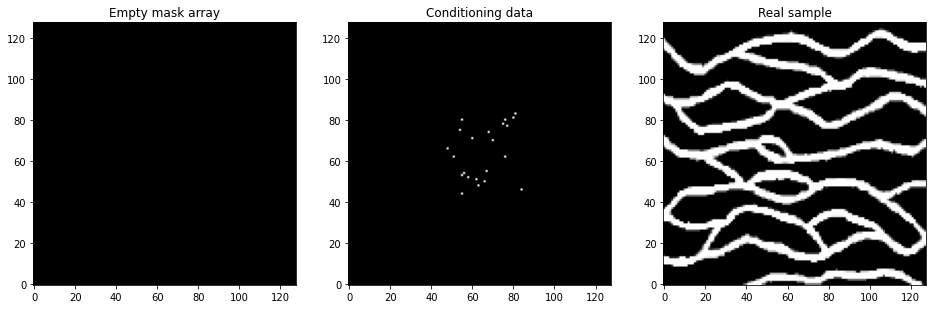

In [12]:
import cv2
from helpers.funcs import read_conditional_samples

conditioning_data = read_conditional_samples("../data/conditioning_data/samples50")["D"]
real_sample = cv2.imread("../data/TI/strebelle.png")/255
real_sample = cv2.resize(real_sample, (128, 128))[:,:,0]

# Hard data
print("[INFO] Loading conditional data")
conditioning_data = convert_to_grid(conditioning_data)
conditioning_data = padding(conditioning_data, 128, 128)

# real_sample = np.resize(conditioning_data, (64, 64))

# Empties conditioning data
cond = np.zeros(conditioning_data.shape)
cond[:, :] = conditioning_data[:, :]
conditioning_data = cond.astype(np.int32)

# Mask array
mask = np.zeros((128, 128))
mask[:,:] = 1

fig, ax = plt.subplots(1, 3, figsize=(16, 9))
ax[0].imshow(mask, cmap="gray", origin='lower')
ax[0].set_title("Empty mask array")

ax[1].imshow(conditioning_data, cmap="gray", origin='lower')
ax[1].set_title("Conditioning data")

ax[2].imshow(real_sample, cmap="gray", origin='lower')
ax[2].set_title("Real sample")

In [13]:
models = []
model_data = []
count = 0

# We only want to generate one conditioned realization here.
while count < 1:
    cond = Conditioner(1, generator, discriminator=discriminator,
                       conditioning_data=real_sample.astype(np.int32), mask=mask,
                       real_sample=real_sample, latent_size=latent_size,
                       verbose=False)
    
    steps, percep_np, content_np, total_np, zhat = cond.condition_logloss(3, [2, 4*2, 4*4], 100)
    x_cond = generator(zhat)
    x_hat_cond = np.where(x_cond.data.cpu().numpy()[0, 0]*0.5+0.5 >= 0.5, 1., 0)
    if 0.85<=f1_score(x_hat_cond[:, :].reshape(-1), conditioning_data[:, :].reshape(-1), average=None)[0] <= 1.0:
        models.append(x_hat_cond)
        model_data.append([steps, percep_np, content_np, total_np, zhat.data.cpu().numpy()])
        count += 1
        print(f"Conditioned training images: {count}")

KeyboardInterrupt: 

### Visualizing generated conditioned images

/tmp/ipykernel_9770/659175397.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


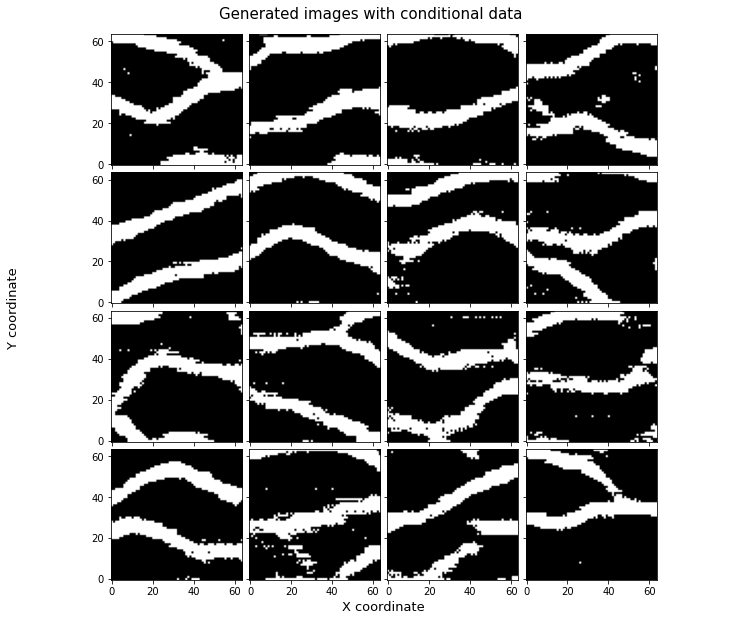

In [128]:
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10, 9))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 4),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, models):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap="gray", origin="lower")

fig.suptitle("Generated images with conditional data", fontsize=15)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("X coordinate", size=13)
plt.ylabel("Y coordinate", size=13)

fig.tight_layout()

plt.show()